# Reddit Community Engagement




## Define Constants and Global Variables

In [0]:

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.google as tf
import collections
import tempfile
import shutil
import time
import itertools

from IPython import display
from google3.pyglib import gfile
from datetime import datetime


# Fraction of the read dataframe to use for learning
current_sample_frac=0.99 #@param
# Fraction of the ML sample to use for test
TEST_FRAC=0.20 #@param


# Options: SubredditClassification, MlbSubredditClassification, CommentsRegression, CommentsClassification
current_learning_goal = 'SubredditClassification'
current_label_col=''
current_feature_cols=''

EXAMPLE_WEIGHT_COL = 'ExampleWeight'

# Add Url and PostId columns so that we can evaluate the quality of our predictions
URL_COL = 'Url'
REDDIT_POSTURL_COL = 'RedditPostUrl'
URL_LIST_COL = 'UrlList'
REDDIT_POSTURL_LIST_COL = 'RedditPostUrlList'

EMB_DIM_K = 2

# Should training runs reuse model directory checkpoints, or restart
RESTART_TRAINING=True #@param
ENABLE_SAVE_TOFILES=True #@param 

# Set preferences for outputs, or leave '' empty for defaults
OUTPUT_DIR_PREFERENCE='./tfprojects' # if set to '' will create subdir under /tmp
RESULTS_DIR_PREFERENCE='' # if set to '' will create subdir under output_dir


"""
Options for current_label_col: 
  Subreddit or RedditSubmitter (for SubredditClassification), 
  SubredditList (for MlbSubredditClassification),
  NumCommentersLogScaled (for CommentsRegression), 
  NumCommentersBin, NumCommentsBin, ScoreBin (for CommentsClassification)
"""

def set_columns_for_goal():
  
  global current_label_col, current_feature_cols
  
  if current_learning_goal=='SubredditClassification':
    current_label_col = 'Subreddit'
  elif current_learning_goal=='MlbSubredditClassification':
    current_label_col = 'SubredditList'
  elif current_learning_goal=='CommentsRegression':
    current_label_col = 'NumCommentersLogScaled'
  elif current_learning_goal=='CommentsClassification':
    current_label_col = 'ScoreBin'
  else:
    current_label_col = 'Subreddit'



  if current_learning_goal=="SubredditClassification":
    current_feature_cols = [URL_COL, REDDIT_POSTURL_COL,"Domain", "Tags", "BOWEntitiesEncoded", "RedditSubmitter", EXAMPLE_WEIGHT_COL]
  elif current_learning_goal=="MlbSubredditClassification":
    current_feature_cols = [URL_LIST_COL, REDDIT_POSTURL_LIST_COL,"Domain", "Tags", "BOWEntitiesEncoded", "RedditSubmitterList", EXAMPLE_WEIGHT_COL] 
  elif current_learning_goal=="CommentsRegression":
    current_feature_cols = [URL_COL, REDDIT_POSTURL_COL,"Domain", "Tags", "BOWEntitiesEncoded", "RedditSubmitter", "Subreddit", EXAMPLE_WEIGHT_COL]
  elif current_learning_goal=="CommentsClassification":
    current_feature_cols = [URL_COL, REDDIT_POSTURL_COL,"Domain", "Tags", "BOWEntitiesEncoded", "RedditSubmitter", "Subreddit", "NumCommentersBin", "ScoreBin", EXAMPLE_WEIGHT_COL]
  else:
    current_feature_cols = [URL_COL, REDDIT_POSTURL_COL,"Domain", "Tags", "BOWEntitiesEncoded", "RedditSubmitter", "Subreddit", EXAMPLE_WEIGHT_COL]

  print('Building model with learning goal: %s, using label column: %s, using feature columns: %s' % (current_learning_goal,current_label_col,current_feature_cols))

  return


 



## Define util functions

In [2]:

"""
Create temp directories for outputs
"""

def create_output_dirs():
  if OUTPUT_DIR_PREFERENCE=='':
    output_dir = tempfile.mkdtemp()
  else:
    output_dir = OUTPUT_DIR_PREFERENCE
  #run_id = datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M')  
  
  if RESULTS_DIR_PREFERENCE=='':
    results_dir = os.path.join(output_dir, 'results')
  else:
    results_dir = RESULTS_DIR_PREFERENCE
  
  tb_log_dir = clean_tb_log_dir(output_dir)
  
  return (output_dir,results_dir, tb_log_dir)

def clean_model_dir():
  model_dir = os.path.join(output_dir, 'model')
  if RESTART_TRAINING==True:
    shutil.rmtree(model_dir, ignore_errors=True)
    os.makedirs(model_dir)
  else:
    os.makedirs(model_dir)
  return model_dir

def clean_tb_log_dir(output_dir):
  tb_log_dir = os.path.join(output_dir, 'tb_log_dir')
  shutil.rmtree(tb_log_dir, ignore_errors=True)
  os.makedirs(tb_log_dir)
  return tb_log_dir

  
"""
Define some basic file I/O ops
"""

def log_dataframe(df, name):
  if ENABLE_SAVE_TOFILES:    
    df.to_csv(gfile.GFile(os.path.join(results_dir,name+'.csv'), 'w'), encoding='utf-8', index_label='dataframe_idx')

def load_raw_dataframe(path):
  # Load it into a pandas dataframe
  df = pd.read_csv(gfile.Open(path), names=types.keys(), dtype=types, na_values="?", header=0)
  print("Size of dataframe: " + str(len(df.index)) + " records") 
  
  return df 

(output_dir, results_dir, tb_log_dir) = create_output_dirs()

print("Location of output (model etc) files: %s " % output_dir)
print("Location of Tensorboard log files: %s " % tb_log_dir)
print("Location of results files: %s" % results_dir)


Location of output (model etc) files: ./tfprojects 
Location of Tensorboard log files: ./tfprojects/tb_log_dir 
Location of results files: ./tfprojects/results


## Get training data from BigQuery

In [0]:
from colabtools import bigquery

PROJECT_ID = 'datancoffee' #@param

bqclient = bigquery.Create(project_id=PROJECT_ID) 
current_exclude_autosubreddits = True
  
def get_bq_data_for_goal():

  query = '''
  WITH 
  s1 AS ( -- Create matches btw reddit and gdelt
    SELECT 
      nwr.DocumentHash,
      ARRAY_AGG(DISTINCT nwr.Url) AS MatchedUrls,
      ARRAY_AGG(DISTINCT nwr.WebResourceHash) AS MatchedNWRs,
      ARRAY_AGG(DISTINCT rwr.WebResourceHash) AS MatchedRWRs, 
      COUNT(*) AS cnt
    FROM discussion_opinions.webresource rwr 
      INNER JOIN news_opinions.webresource nwr ON nwr.Url = rwr.MetaFields[SAFE_OFFSET(0)]
    WHERE 
      rwr.MetaFields[SAFE_OFFSET(0)] <> 'unavailable' -- 0-index metafield contains external URL
      AND nwr._PARTITIONTIME BETWEEN TIMESTAMP('2017-06-01') AND TIMESTAMP('2017-09-30') 
      AND rwr._PARTITIONTIME BETWEEN TIMESTAMP('2017-06-01') AND TIMESTAMP('2017-09-30') 
    GROUP BY 1
    ORDER BY 5 DESC
  )
  -- SELECT * FROM s1 LIMIT 1000
  -- SELECT COUNT(*) FROM s1 -- 200265
  , s2a AS (
    SELECT nd.DocumentHash, 
      nd.PublicationTime AS NewsPubTime,   
      nd.Author AS NewsAuthor, 
      ARRAY_AGG(REGEXP_REPLACE(tag.Tag,"[ | [:punct:]]","_")) AS TagArray   
    FROM s1
      INNER JOIN news_opinions.document nd ON nd.DocumentHash = s1.DocumentHash, UNNEST(nd.Tags) AS tag
    GROUP BY 1,2,3
  )
  , s2b AS (
    SELECT tag, COUNT(DISTINCT DocumentHash) cnt FROM s2a, UNNEST(s2a.TagArray) AS tag 
    GROUP BY 1 HAVING COUNT(DISTINCT DocumentHash) >= 3
  )
  -- SELECT COUNT(*) FROM s2b -- 52264
  , s2c AS (
    SELECT DocumentHash, tag2 AS Tag
    FROM s2a, UNNEST(s2a.TagArray) AS tag2
      INNER JOIN s2b ON s2b.tag = tag2
  )
  , s2 AS (
    SELECT s2a.DocumentHash, 
      s2a.NewsPubTime,   
      s2a.NewsAuthor,
      ARRAY_TO_STRING(ARRAY_AGG(s2c.Tag)," ") AS Tags
    FROM s2a
      LEFT OUTER JOIN s2c ON s2c.DocumentHash = s2a.DocumentHash
    GROUP BY 1,2,3
  )
  -- SELECT COUNT(*) FROM s2 --198657
  -- SELECT * FROM s2 LIMIT 1000
  , s3 AS (
    SELECT s1.DocumentHash, 
      rwr.Author AS RedditSubmitter,
      rwr.PublicationTime AS RedditPubTime,
      rwr.MetaFields[SAFE_OFFSET(4)] AS Domain, 
      rwr.MetaFields[SAFE_OFFSET(0)] AS Url,
      rwr.MetaFields[SAFE_OFFSET(1)] AS Subreddit,
      rwr.MetaFields[SAFE_OFFSET(2)] AS Score,
      rwr.CollectionItemId AS RedditPostId
    FROM s1, UNNEST(s1.MatchedRWRs) AS rwrHash
      INNER JOIN discussion_opinions.webresource rwr ON rwr.WebResourceHash = rwrHash
    GROUP BY 1,2,3,4,5,6,7,8
  ),
  -- SELECT * FROM s3 LIMIT 1000
  -- SELECT COUNT(*) FROM s3 -- 429648
  s3aa AS (
    SELECT Url FROM s3 GROUP BY 1
  ),
  s3ab AS (
    SELECT gkg.DocumentIdentifier, gkg.V2Themes, gkg.AllNames, gkg.V2Locations
    FROM `gdelt-bq.gdeltv2.gkg` gkg 
      INNER JOIN s3aa ON s3aa.Url = gkg.DocumentIdentifier
  )
  ,s3ac AS ( -- Mentions of Themes
    SELECT s3ab.DocumentIdentifier, SPLIT(theme_mentions,',')[SAFE_OFFSET(0)] AS Entity, SPLIT(theme_mentions,',')[SAFE_OFFSET(1)] AS Offset
    FROM s3ab, UNNEST(SPLIT(s3ab.V2Themes,";")) AS theme_mentions
  )
  -- SELECT * FROM s3ac LIMIT 1000
  ,s3ad AS (
    SELECT s3ab.DocumentIdentifier, 
      REPLACE(SPLIT(name_mentions,',')[SAFE_OFFSET(0)],' ','_') AS Name, 
      SPLIT(name_mentions,',')[SAFE_OFFSET(1)] AS Offset
    FROM s3ab, UNNEST(SPLIT(s3ab.AllNames,";")) AS name_mentions
  )
  -- SELECT * FROM s3ad LIMIT 1000
  ,s3ae AS ( -- Calculate frequency stats for Name mentions
    SELECT Name, COUNT(DISTINCT DocumentIdentifier) FROM s3ad 
    GROUP BY 1 HAVING COUNT(DISTINCT DocumentIdentifier) >= 10
  )
  -- SELECT * FROM s3ae LIMIT 1000
  ,s3af AS (-- Filter mentions of Names
    SELECT s3ad.DocumentIdentifier, s3ad.Name AS Entity, s3ad.Offset
    FROM s3ad INNER JOIN s3ae ON s3ae.Name = s3ad.Name
  )
  -- SELECT DISTINCT Entity FROM s3af
  ,s3ag AS ( -- Mentions of Locations
    SELECT s3ab.DocumentIdentifier, SPLIT(loc_mentions,'#') AS LocFieldArray 
    FROM s3ab, UNNEST(SPLIT(s3ab.V2Locations,";")) AS loc_mentions
  )
  -- SELECT * FROM s3ag LIMIT 1000
  ,s3ah AS (
    SELECT 
      s3ag.DocumentIdentifier, 
      REPLACE(REPLACE(LocFieldArray[SAFE_OFFSET(1)],' ','_'),',','_') AS Loc, 
      LocFieldArray[SAFE_OFFSET(8)] AS Offset
    FROM s3ag
  )
  ,s3ai AS ( -- Calculate frequency stats for Location mentions
    SELECT Loc, COUNT(DISTINCT DocumentIdentifier) FROM s3ah 
    GROUP BY 1 HAVING COUNT(DISTINCT DocumentIdentifier) >= 10
  )
  -- SELECT * FROM s3ae LIMIT 1000
  ,s3aj AS ( -- Filter mentions of Locations
    SELECT s3ah.DocumentIdentifier, s3ah.Loc AS Entity, s3ah.Offset
    FROM s3ah INNER JOIN s3ai ON s3ai.Loc = s3ah.Loc
  )
  ,s3ak AS ( -- Join all Themes, Locations, Names
    SELECT DocumentIdentifier, Entity, Offset FROM s3ac
    UNION ALL
    SELECT DocumentIdentifier, Entity, Offset FROM s3af
    UNION ALL
    SELECT DocumentIdentifier, Entity, Offset FROM s3aj
  ) 
  -- SELECT COUNT(DISTINCT Entity) FROM s3ak -- 36412
  ,s3an AS ( -- Create Encoding for Entities
    SELECT Entity, cnt, CAST(RANK() OVER (ORDER BY cnt DESC, Entity ASC) AS STRING) AS EntityIdx 
    FROM (SELECT Entity, COUNT(*) AS cnt FROM s3ak GROUP BY 1) 
  )
  -- SELECT * FROM s3an ORDER BY CAST(EntityIdx AS INT64) ASC LIMIT 1000
  ,s3a AS (
    SELECT DocumentIdentifier, 
      STRING_AGG(DISTINCT EntityIdx," ") AS BOWEntitiesEncoded, -- For Bag-of-Words encoding order is not important
      COUNT(DISTINCT s3ak.Entity) AS BOWEncodingLength,
      STRING_AGG(DISTINCT s3ak.Entity," ") AS EntitiesBOW 
      -- STRING_AGG(EntityIdx," " ORDER BY Offset ASC) AS EntitiesSeqEncoded, -- For CNN and RNN analysis, use Entity Sequence
      -- COUNT(*) AS EntitiesSeqLength,
      -- STRING_AGG(s3ak.Entity," " ORDER BY Offset ASC) AS EntitiesSeq
    FROM s3ak
      INNER JOIN s3an ON s3ak.Entity = s3an.Entity
    WHERE s3ak.Entity<>""
    GROUP BY 1
  )
  -- SELECT * FROM s3a LIMIT 1000
  -- SELECT COUNT(*) FROM s3a -- 429648
  , s3b AS (
    SELECT s3.RedditPostId, 
      COUNT(DISTINCT rwr.Author) AS NumCommenters,
      COUNT(*) AS NumComments
    FROM s3
      INNER JOIN discussion_opinions.webresource rwr ON rwr.MetaFields[SAFE_OFFSET(3)] = s3.RedditPostId
    WHERE rwr.Author <> '[deleted]' 
      AND rwr.ParentWebResourceHash IS NOT NULL -- exclude the actual post item
    GROUP BY 1
  )
  -- SELECT * FROM s3b WHERE NumComments < 10 ORDER BY NumCommenters DESC LIMIT 1000
  -- SELECT COUNT(*) FROM s3b -- 419004
  , s4 AS (
    SELECT s2.*, 
      s3.Domain, 
      s3.Url,
      CONCAT("https://www.reddit.com/r/",s3.Subreddit,"/comments/", SUBSTR(s3.RedditPostId,4), "/") AS RedditPostUrl,
      s3.RedditSubmitter,
      s3.RedditPubTime,
      s3.Subreddit,
      s3.Score,
      IFNULL(s3b.NumCommenters,0) AS NumCommenters,
      IFNULL(s3b.NumComments,0) AS NumComments,
      TIMESTAMP_DIFF(s3.RedditPubTime, s2.NewsPubTime,  MINUTE) AS PostSubmitDelay,
      s3a.BOWEntitiesEncoded,
      s3a.BOWEncodingLength,
      s3a.EntitiesBOW
      -- s3a.EntitiesSeqEncoded,
      -- s3a.EntitiesSeqLength,
      -- s3a.EntitiesSeq
    FROM s2 
      INNER JOIN s3 ON s3.DocumentHash = s2.DocumentHash
      LEFT OUTER JOIN s3b ON s3b.RedditPostId = s3.RedditPostId
      LEFT OUTER JOIN s3a ON s3a.DocumentIdentifier = s3.Url
  )
  -- SELECT COUNT(*) FROM s4 -- 425548 / 425548
  -- SELECT * FROM s4 LIMIT 1000
  , s5 AS ( -- Creates a ranking of Subreddits based on frequency of posts
    SELECT Subreddit, cnt, RANK() OVER (ORDER BY cnt DESC) AS SubredditRank
    FROM (SELECT Subreddit, COUNT(*) AS cnt FROM s4 GROUP BY 1)
  )
  , s8 AS (
    SELECT s4.*
      , (CASE WHEN s5.SubredditRank < 200 THEN 1 ELSE 0 END) AS IsTop200Subreddit
    FROM s4
      INNER JOIN s5 ON s5.Subreddit = s4.Subreddit
  )
  , s9 AS (
    SELECT
      s8.DocumentHash,
      s8.RedditPostUrl,
      s8.Url,
      s8.Domain,
      s8.RedditSubmitter AS RedditSubmitter,
      s8.Subreddit,
      s8.Score,
      s8.NumCommenters,
      s8.NumComments,
      s8.Tags,
      IFNULL(s8.BOWEntitiesEncoded,"") AS BOWEntitiesEncoded,
      IFNULL(s8.BOWEncodingLength,0) AS BOWEncodingLength,
      IFNULL(s8.EntitiesBOW,"") AS EntitiesBOW,
      -- IFNULL(s8.EntitiesSeqEncoded,"") AS EntitiesSeqEncoded,
      -- IFNULL(s8.EntitiesSeqLength,0) AS EntitiesSeqLength,
      -- IFNULL(s8.EntitiesSeq,"") AS EntitiesSeq,
      (CASE WHEN s8.Subreddit LIKE '%auto' OR s8.Subreddit IN ('AutoNewspaper','UMukhasimAutoNews','newsbotbot','TheNewsFeed') THEN 1 ELSE 0 END) AS IsAutoSubreddit,
      IsTop200Subreddit
    FROM s8
    GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
  )
  '''


  if current_learning_goal == 'SubredditClassification':
    query += '''SELECT Url, RedditPostUrl, Domain, RedditSubmitter, Subreddit, Tags, BOWEntitiesEncoded FROM s9 WHERE IsTop200Subreddit = 1 '''
    query += ''' AND s9.IsAutoSubreddit = 0 ''' if current_exclude_autosubreddits == True else ''' '''
      
  elif current_learning_goal == 'MlbSubredditClassification':
    query += '''
  SELECT DocumentHash, Domain, Tags, BOWEntitiesEncoded, 
    STRING_AGG(DISTINCT Url," ") AS UrlList,
    STRING_AGG(DISTINCT RedditPostUrl," ") AS RedditPostUrlList,
    STRING_AGG(DISTINCT RedditSubmitter," ") AS RedditSubmitterList, 
    STRING_AGG(DISTINCT Subreddit," ") AS SubredditList,
    MAX(Score) AS Score,
    SUM(NumCommenters) AS NumCommenters,
    SUM(NumComments) AS NumComments
  FROM s9 
  WHERE IsTop200Subreddit = 1 '''
    query += ''' AND s9.IsAutoSubreddit = 0 ''' if current_exclude_autosubreddits == True else ''' '''
    query += '''GROUP BY 1,2,3,4 '''
  else:
    query += '''
    SELECT 
      Url, RedditPostUrl, Domain, RedditSubmitter, Subreddit, Tags, 
      BOWEntitiesEncoded, Score, NumCommenters, NumComments 
    FROM s9 '''
    query += ''' WHERE s9.IsAutoSubreddit = 0 ''' if current_exclude_autosubreddits == True else ''' '''


  df = bigquery.ExecuteQuery(query=query, start_row=0, max_rows = 500000, use_legacy_sql=False)
  print("Size of reddit set: %s records" % len(df.index)) 

  # Dump reddit dataset to CSV for inspection
  log_dataframe(df,'010-bq-results')

  return df

reddit_df = pd.DataFrame()



## Define Transforms of Raw Data into Feature Columns & Input Functions



In [0]:
current_inverse_frequency_pow = 0.75 # used in weight_inverse_to_freq


def get_train_test_sets(fullset_df, train_size, test_size, seed=None):
  """
  Args:
    seed: The random seed to use when shuffling the data. `None` generates a
      unique shuffle every run.
  Returns:
    a pair of training data, and test data:
    `(train, test)`
  """

  # Shuffle the data
  np.random.seed(seed)

  # Split the data into train/test subsets.
  sample_size = train_size + test_size
  sample_df = fullset_df.sample(n=sample_size, random_state=seed)
  train = sample_df.head(train_size)
  test = sample_df.drop(train.index)

  return (train, test)

  
# Split the Dataframe
def split_features_labels(raw_df, feature_cols, label_col):
  
  features=pd.DataFrame({k: raw_df[k].values for k in feature_cols})
  labels=pd.Series(raw_df[label_col].values)

  return (features,labels) 

def embedding_dims(num_tokens, k=2):
  return np.ceil(k * (num_tokens**0.25)).astype(int)


def space_tokenizer_fn(iterator):
  
  for x in iterator:
    if x is not None:
      yield x.split(" ")
    else:
      yield []
      
    
def int_converter_fn(a):
  return np.asarray([int(i) for i in a],dtype=int)


"""
Normalization utilities compliments of
  https://github.com/google/eng-edu/blob/master/ml/cc/exercises/improving_neural_net_performance.ipynb
"""
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def log1p_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def log_10_1p_normalize(series):
  return series.apply(lambda x:math.log10(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

"""
Label Weighting Functions
"""
def scorebin_weight(series):
  return series.apply(lambda x:(0.5 if x == "1" else 1.0)  )

def weight_inverse_to_freq(series):
  """
  Will calculate a weight inverse to the frequency of the label class, 
    making small classes more important than indicated by their frequency.
    Uses sqrt so as not to diminish the importance of very large classes.
  """
  val_counts = series.value_counts()
  min_val = val_counts.min()

  return series.apply(lambda x: ((min_val / float(val_counts[x]))**current_inverse_frequency_pow) )


def add_engineered_columns(df, learning_goal):
  
  # rule of thumb, NN's train best when the input features are roughly on the same scale
  
  if learning_goal == "CommentsRegression" or learning_goal == "CommentsClassification":
    df["Score"] = df["Score"].astype(int)    
    
    df["NumCommentersClipped"] = ( clip(df["NumCommenters"],0, (10**4 - 1)) )
    df["NumCommentsClipped"] = ( clip(df["NumComments"],0, (10**5 - 1)) )
    df["ScoreClipped"] = ( clip(df["Score"],0, (10**4 - 1)) )
    
    df["NumCommentersLogScaled"] = ( log_10_1p_normalize(df["NumCommentersClipped"]) )
    df["NumCommentsLogScaled"] = ( log_10_1p_normalize(df["NumCommentsClipped"]) )
    df["ScoreLogScaled"] = ( log_10_1p_normalize(df["ScoreClipped"]) )
    
    # This will result in following binning of ScoreBin<-Score: 0: 0, 1: 1-9, 2: 10-99, 3: 100-999, 4: 1000-9999 etc
    df["NumCommentersBin"] = (np.ceil(df["NumCommentersLogScaled"]).astype(int).astype(str))
    df["NumCommentsBin"] = (np.ceil(df["NumCommentsLogScaled"]).astype(int).astype(str))
    df["ScoreBin"] = (np.ceil(df["ScoreLogScaled"]).astype(int).astype(str))
  
    df[EXAMPLE_WEIGHT_COL] = weight_inverse_to_freq(df[current_label_col])
      
  else:
    df[EXAMPLE_WEIGHT_COL] = 1.0
    
  return

def convert_series_to_nparray(s):
  """
  Converts a pandas Series to a numpy array
  """
  nparray = s.values.astype(type(s[0]))
  return nparray


def create_train_test_features_labels():

  # Add Engineered Columns
  add_engineered_columns(reddit_df,learning_goal = current_learning_goal)


  # Log results to file
  log_dataframe(reddit_df,'030-with-engineered-cols')

  reddit_size=len(reddit_df.index)
  sample_size=int(np.floor(reddit_size * current_sample_frac))
  test_size=int(np.floor(sample_size * TEST_FRAC))
  train_size=sample_size - test_size

  (train, test) = get_train_test_sets(fullset_df=reddit_df, train_size=train_size, test_size=test_size,seed=3)
  print("Size of train set: %d records" %len(train.index)) 
  print("Size of test set: %d records" % len(test.index)) 

  # Log results to file
  log_dataframe(train,'040-train')
  log_dataframe(test,'050-test')


  # Create training and validation splits
  training_features, training_labels = split_features_labels(raw_df = train, feature_cols=current_feature_cols, label_col=current_label_col)
  validation_features, validation_labels = split_features_labels(raw_df = test, feature_cols=current_feature_cols, label_col=current_label_col)

  return (training_features, training_labels,validation_features, validation_labels)


training_features = pd.DataFrame()
training_labels = pd.Series()
validation_features = pd.DataFrame()
validation_labels = pd.Series()



## Keras Multi-Label Model

In [5]:
# Keras Multi-Label Model: Tags -> Subreddit

from keras.models import Model, Input
from keras.layers import Flatten, Dense, Dropout, Embedding, Activation, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.utils
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import bisect
from sklearn import metrics
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.metrics import top_k_categorical_accuracy 

BATCH_SIZE = 50  
VALIDATION_SPLIT = 0.1
current_epochs = 2

# Hidden Layers configuration
HIDDEN_UNITS_L1 = 500
DROPOUT_L1 = 0.3

TAGS_MAX_SEQUENCE_LENGTH = 7
TAGS_MAX_NUM_TOKENS=None # don't limit Tags dictionary 

ENTITIES_MAX_SEQUENCE_LENGTH = 100
ENTITIES_MAX_NUM_TOKENS=None # don't limit Entities dictionary 


def create_bow_input(train, test, max_sequence_length, max_num_tokens=None):

  """
  Args
    max_num_tokens: if None, will use the entire dictionary of tokens found
  """
  
  tokenizer = Tokenizer(num_words=max_num_tokens,filters='')
  tokenizer.fit_on_texts(train)

  vocab_size = len(tokenizer.word_index) 
  # when creating Embedding layer, we will add 1 to input_dims 
  # to account for the padding 0
  actual_num_tokens = vocab_size if max_num_tokens == None else min(max_num_tokens,vocab_size)

  train_enc = tokenizer.texts_to_sequences(train)
  test_enc = tokenizer.texts_to_sequences(test)

  train_enc = pad_sequences(train_enc, maxlen=max_sequence_length, padding='post')
  test_enc = pad_sequences(test_enc, maxlen=max_sequence_length, padding='post')

  inverted_dict = dict([[v,k] for k,v in tokenizer.word_index.items()])
  
  return (train_enc, test_enc, inverted_dict, actual_num_tokens)

def create_bow_embedded_layer(train, test, feature_key, max_sequence_length, max_num_tokens ):
  
  """
    Args:
      train, test - string columns that need to be encoded with integers
  """
  
  (train_enc, test_enc, inverted_dict, actual_num_tokens) = create_bow_input(
      train=train,
      test=test,
      max_sequence_length=max_sequence_length,
      max_num_tokens=max_num_tokens)

  print("Using %d unique values for %s" % (actual_num_tokens,feature_key))

  # the very first input layer for the feature
  input_layer = Input(shape=(train_enc.shape[1],), name=feature_key)

  # Embedding layer 
  # When embedding, use (tags_actual_num_tokens +1) to account for the padding 0
  num_embedding_dims= embedding_dims(actual_num_tokens,EMB_DIM_K)
  embedding_layer = Embedding(
      input_dim = (actual_num_tokens +1), # to account for the padding 0
      output_dim = num_embedding_dims, 
      input_length=max_sequence_length,
      #mask_zero=True
      )(input_layer)

  # Adding LSTM layer will work best on sequential data. An LSTM will transform 
  # the vector sequence into a single vector, containing information about the 
  # entire sequence
  # lstm_layer = LSTM(32)(embedding_layer)
  # lstm_layer = LSTM(64,return_sequences=True)(embedding_layer)

  # Flatten on top of a Embedding will create a bag-of-words matrix
  bagofwords_layer = Flatten()(embedding_layer)
  
  return (train_enc, test_enc, inverted_dict, actual_num_tokens, input_layer, bagofwords_layer)


def create_categorical_label_or_feature(training_nparray, test_nparray, min_frequency=0, vocab_order=None):

  """
  Use VocabularyProcessor because sklearn LabelEncoder() does not support 
  unseen values in test dataset
  """
  vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
      max_document_length = 1, 
      tokenizer_fn = space_tokenizer_fn,
      min_frequency=min_frequency
      #vocabulary=tf.contrib.learn.preprocessing.CategoricalVocabulary()
  )
  
  if vocab_order is not None:
    vocab_processor.fit(vocab_order)
  else:
    vocab_processor.fit(training_nparray)
    
  train_enc = vocab_processor.transform(training_nparray)
  # transform test set using training encoding. Words not found in train set will be set as unknown
  test_enc = vocab_processor.transform(test_nparray)  
  
  train_enc = np.array(list(train_enc))
  test_enc = np.array(list(test_enc))
  
  # VocabularyProcessor outputs a word-id matrix where word ids start from 1 
  # and 0 means 'no word'. We do not have to subtract 1 from the index, because
  # keras to_categorical works well with that. We also use 0 to pad sequences.
  classes = vocab_processor.vocabulary_._reverse_mapping
  num_classes = len(classes)

  # convert to one-hot representation
  train_enc = keras.utils.to_categorical(train_enc, num_classes=num_classes) 
  test_enc = keras.utils.to_categorical(test_enc, num_classes=num_classes)
  
  return (train_enc, test_enc, num_classes, classes)

def create_multi_label(training_nparray, test_nparray, max_num_classes=None):

  tokenizer = Tokenizer(num_words=max_num_classes,filters='')
  tokenizer.fit_on_texts(training_nparray)

  num_classes = len(tokenizer.word_index) + 1 # for the 0 index unknown class
  actual_num_classes = num_classes if max_num_classes == None else min(max_num_classes,num_classes)

  train_enc = tokenizer.texts_to_matrix(training_nparray)
  test_enc = tokenizer.texts_to_matrix(test_nparray)

  inverted_dict = dict([[v,k] for k,v in tokenizer.word_index.items()])
  
  return (train_enc, test_enc, actual_num_classes, inverted_dict)
  

def compile_and_fit_model(inputs = [], outputs=[], use_sample_weights=False, k_of_top_k_accuracy=5):
  
  # Prepare output or input: Subreddit
  if ('Subreddit' in inputs) or ('Subreddit' in outputs):
    global subreddit_train, subreddit_test, num_subreddit_classes, subreddit_classes
    subreddit_train_nparray = convert_series_to_nparray(training_labels) if ('Subreddit' in outputs) else training_features['Subreddit']
    subreddit_test_nparray = convert_series_to_nparray(validation_labels) if ('Subreddit' in outputs) else validation_features['Subreddit']
    
    if current_learning_goal in ['SubredditClassification','CommentsClassification']:
      (subreddit_train, subreddit_test, num_subreddit_classes, subreddit_classes) = create_categorical_label_or_feature(
        training_nparray = subreddit_train_nparray,
        test_nparray = subreddit_test_nparray)  

    elif current_learning_goal=="MlbSubredditClassification":
      (subreddit_train, subreddit_test, num_subreddit_classes, subreddit_classes) = create_multi_label(
        training_nparray = subreddit_train_nparray,
        test_nparray = subreddit_test_nparray)  
    print('Using %d unique values for subreddit' % num_subreddit_classes)
    # Input layer for subreddit
    if ('Subreddit' in inputs):
      subreddit_input = Input(shape=(subreddit_train.shape[1],), name='Subreddit')

    
  # Prepare input: Domain
  if 'Domain' in inputs:
    global domain_train, domain_test, num_domain_classes, domain_classes
    (domain_train, domain_test, num_domain_classes, domain_classes) = create_categorical_label_or_feature(
        training_nparray = training_features['Domain'],
        test_nparray = validation_features['Domain'])  
    print("Using %d unique values for domain" % num_domain_classes)
    # Input layer for domain
    domain_input = Input(shape=(domain_train.shape[1],), name='Domain')

  # Prepare input/output: RedditSubmitter

  if ('RedditSubmitter' in inputs) or ('RedditSubmitter' in outputs):
    global submitter_train, submitter_test, num_submitter_classes, submitter_classes
    (submitter_train, submitter_test, num_submitter_classes, submitter_classes) = create_categorical_label_or_feature(
        training_nparray = training_features['RedditSubmitter'],
        test_nparray = validation_features['RedditSubmitter'],
        min_frequency = 4)  
    print("Using %d unique values for submitter" % num_submitter_classes)
    # Input layer for submitter
    if ('RedditSubmitter' in inputs):
      submitter_input = Input(shape=(submitter_train.shape[1],), name='RedditSubmitter')

  # Prepare input: Tags

  #global tags_train, tags_test, tags_inverted_dict, tags_actual_num_tokens, tags_input, tags_bagofwords
  if 'Tags' in inputs:
    global tags_train, tags_test, tags_inverted_dict, tags_actual_num_tokens, tags_input, tags_bagofwords
    (tags_train, tags_test, tags_inverted_dict, tags_actual_num_tokens, tags_input, tags_bagofwords) = create_bow_embedded_layer(
        train = training_features['Tags'], 
        test = validation_features['Tags'], 
        feature_key = 'Tags', 
        max_sequence_length = TAGS_MAX_SEQUENCE_LENGTH,
        max_num_tokens = TAGS_MAX_NUM_TOKENS)

  # Prepare input: GDELT Entities 

  if 'BOWEntitiesEncoded' in inputs:
    global entities_train, entities_test, entities_inverted_dict, entities_actual_num_tokens, entities_input, entities_bagofwords
    (entities_train, entities_test, entities_inverted_dict, entities_actual_num_tokens, entities_input, entities_bagofwords) = create_bow_embedded_layer(
        train=training_features['BOWEntitiesEncoded'],
        test=validation_features['BOWEntitiesEncoded'],
        feature_key = 'BOWEntitiesEncoded',
        max_sequence_length=ENTITIES_MAX_SEQUENCE_LENGTH,
        max_num_tokens=ENTITIES_MAX_NUM_TOKENS)

  if ('ScoreBin' in outputs):
    global scorebin_train, scorebin_test, num_scorebin_classes, scorebin_classes
    vocab_order = np.sort(training_labels.unique())
    (scorebin_train, scorebin_test, num_scorebin_classes, scorebin_classes) = create_categorical_label_or_feature(
        training_nparray = training_features['ScoreBin'],
        test_nparray = validation_features['ScoreBin'],
        vocab_order=vocab_order)  
    print("Using %d unique values for ScoreBin" % num_scorebin_classes)

  if ('NumCommentersBin' in outputs):
    global numcommentersbin_train, numcommentersbin_test, num_numcommentersbin_classes, numcommentersbin_classes
    vocab_order = np.sort(training_features['NumCommentersBin'].unique())
    (numcommentersbin_train, numcommentersbin_test, num_numcommentersbin_classes, numcommentersbin_classes) = create_categorical_label_or_feature(
        training_nparray = training_features['NumCommentersBin'],
        test_nparray = validation_features['NumCommentersBin'],
        vocab_order=vocab_order) 
    print("Using %d unique values for NumCommentersBin" % num_numcommentersbin_classes)
    
    
  ##########################  
  # Merge input branches and build the model
  ##########################

  def _create_subreddit_model(model_type='multiclass'):
    """
      Creates Multi-Class Single-Label model using softmax
    """
    
    # Bring together the Inputs
    input_layers = []
    preconcat_layers = []
    for s in inputs:
      if s=='Tags':
        input_layers.append(tags_input)
        preconcat_layers.append(tags_bagofwords)
      elif s=='BOWEntitiesEncoded':
        input_layers.append(entities_input)
        preconcat_layers.append(entities_bagofwords)
      elif s=='Domain':
        input_layers.append(domain_input)
        preconcat_layers.append(domain_input)
      elif s=='RedditSubmitter':
        input_layers.append(submitter_input)
        preconcat_layers.append(submitter_input)
      elif s=='Subreddit':
        input_layers.append(subreddit_input)
        preconcat_layers.append(subreddit_input)

    if len(preconcat_layers) > 1:
      joined_1 = keras.layers.concatenate(preconcat_layers, axis=-1)
    elif len(preconcat_layers) == 1:
      joined_1 = preconcat_layers[0]
    else:
      raise ValueError('No valid inputs among %s' % (','.join(inputs)))
      
    # Connect to Hidden Layers
    hidden_1 = Dense(HIDDEN_UNITS_L1, activation='relu')(joined_1)
    dropout_1 = Dropout(DROPOUT_L1)(hidden_1)
    
    if model_type=='multiclass':
      output_activation='softmax'
      loss_function = 'categorical_crossentropy'
    elif model_type=='multilabel':
      output_activation='sigmoid'
      loss_function = 'binary_crossentropy'
    
    # Add the outputs
    output_layers = []
    for s in outputs:
      if s=='Subreddit':
        layer = Dense(num_subreddit_classes, activation=output_activation, name='subreddit_output')(dropout_1)
        output_layers.append(layer)
      elif s=='RedditSubmitter':
        layer = Dense(num_submitter_classes, activation=output_activation, name='submitter_output')(dropout_1)
        output_layers.append(layer)
      elif s=='ScoreBin':
        layer = Dense(num_scorebin_classes, activation=output_activation, name='scorebin_output')(dropout_1)
        output_layers.append(layer)
      elif s=='NumCommentersBin':
        layer = Dense(num_numcommentersbin_classes, activation=output_activation, name='numcommentersbin_output')(dropout_1)
        output_layers.append(layer)
        
    model = Model(inputs=input_layers, outputs=output_layers)

    
    def top_k_accuracy(y_true, y_pred):
      return top_k_categorical_accuracy(y_true, y_pred, k=k_of_top_k_accuracy)
    
    if k_of_top_k_accuracy==5:
      metrics=['accuracy','top_k_categorical_accuracy']
    else:
      metrics=['accuracy',top_k_accuracy]
    
    model.compile(optimizer='adam',
                  loss=loss_function,
                  # loss_weights=[1., 0.2]
                  metrics=metrics)
                 

    return model
  
  global x_train, x_test, y_train, y_test
  
  if current_learning_goal in ['SubredditClassification','CommentsClassification']:
    model = _create_subreddit_model(model_type='multiclass')  
  elif current_learning_goal=="MlbSubredditClassification":
    model = _create_subreddit_model(model_type='multilabel')

  x_train = {}
  x_test = {}
  
  for s in inputs:
    
    if s=='Tags':
      x_train['Tags'] = tags_train
      x_test['Tags'] = tags_test
    elif s=='BOWEntitiesEncoded':
      x_train['BOWEntitiesEncoded'] = entities_train
      x_test['BOWEntitiesEncoded'] = entities_test
    elif s=='Domain':
      x_train['Domain'] = domain_train
      x_test['Domain'] = domain_test
    elif s=='RedditSubmitter':
      x_train['RedditSubmitter'] = submitter_train
      x_test['RedditSubmitter'] = submitter_test
    elif s=='Subreddit':
      x_train['Subreddit'] = subreddit_train
      x_test['Subreddit'] = subreddit_test
   
  y_train = {}
  y_test = {}

  for s in outputs:
    
    if s=='Subreddit':
      y_train['subreddit_output'] = subreddit_train
      y_test['subreddit_output'] = subreddit_test
    elif s=='RedditSubmitter':
      y_train['submitter_output'] = submitter_train
      y_test['submitter_output'] = submitter_test
    elif s=='ScoreBin':
      y_train['scorebin_output'] = scorebin_train
      y_test['scorebin_output'] = scorebin_test
    elif s=='NumCommentersBin':
      y_train['numcommentersbin_output'] = numcommentersbin_train
      y_test['numcommentersbin_output'] = numcommentersbin_test
    
  
  """
  callbacks = [
      keras.callbacks.TensorBoard(
          log_dir=tb_log_dir,                  
          histogram_freq=1,                      
          embeddings_freq=1,                     
      )
  ]
  """
  
  if use_sample_weights==True:
    if len(outputs) == 1:
      sample_weight = np.array(training_features[EXAMPLE_WEIGHT_COL])
    else:
      sample_weight = []
      for s in outputs:
        sample_weight.append(np.array(training_features[EXAMPLE_WEIGHT_COL]))
  else:
    sample_weight = None

  
  history = model.fit(x_train, y_train, 
            epochs=current_epochs, batch_size=BATCH_SIZE,
            verbose=2, validation_split=VALIDATION_SPLIT,
            sample_weight = sample_weight)

  score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)

  if len(outputs)==1:
    print('Test data loss: %.3f; top 1 accuracy: %.3f; top %d accuracy: %.3f;'%(score[0],score[1], k_of_top_k_accuracy, score[2]))
  elif len(outputs)==2:
    print('Test metrics: total loss: %.3f; output_1 loss: %.3f; output_2 loss: %.3f; output_1 top 1 accuracy: %.3f; output_1 top %d accuracy: %.3f; output_2 top 1 accuracy: %.3f; output_2 top %d accuracy: %.3f;'%(score[0],score[1],score[2],score[3],k_of_top_k_accuracy,score[4],score[5],k_of_top_k_accuracy,score[6]))

  return (model, history, x_train, x_test, y_train, y_test)

def get_true_and_predicted_labels(model, x_test, y_test_selected, label_classes, multi_output=True, output_idx=0):
  
  """
    Run predictions and determine y_true and y_pred filled with labels, not indexes 
  """
  y_pred_probs = model.predict(x_test) # shape: num outputs x num samples x num classes
  y_pred_probs = np.array(y_pred_probs)

  if multi_output==True:
    y_pred_idx = np.argmax(y_pred_probs[output_idx],axis=1) 
  else:
    y_pred_idx = np.argmax(y_pred_probs,axis=1) 
    
  y_true_idx = np.argmax(y_test_selected,axis=1)

  y_pred = np.array([label_classes[i] for i in y_pred_idx])
  y_true = np.array([label_classes[i] for i in y_true_idx])

  return (y_true, y_pred)





Using TensorFlow backend.


## Calculate Multi-Label Metrics

In [0]:
# Multi-Label Accuracy calculation based on https://github.com/suraj-deshmukh/Multi-Label-Image-Classification/blob/master/miml.ipynb

from sklearn.metrics import matthews_corrcoef, hamming_loss, label_ranking_loss, accuracy_score
from sklearn.metrics import roc_curve, auc

CASE_TYPE_HEADERS = ['100% TP+TN','50%+ TP', '1-49% TP', '0% TP']


def eval_multilabel_metrics(model, x_test, y_true):
  """
  Returns:
    y_pred = the matrix of predicted labels
  """
  y_pred_probs = model.predict(x_test)
  y_pred_probs = np.array(y_pred_probs)

  ttl_test_samples = y_true.shape[0] 
  num_classes = y_true.shape[1]


  threshold = np.arange(0.05,0.95,0.05)

  acc = []
  accuracies = []
  best_threshold = np.zeros(y_pred_probs.shape[1])
  for i in range(y_pred_probs.shape[1]):
      y_prob = np.array(y_pred_probs[:,i])
      
      old_settings = np.seterr(all='ignore') # prevent warnings. matthews_corrcoef handles the NaN case
      for j in threshold:
          y_pred = [1 if prob>=j else 0 for prob in y_prob]
          mcc = matthews_corrcoef(y_true[:,i],y_pred)
          acc.append(mcc)
      np.seterr(**old_settings)

      acc   = np.array(acc)
      index = np.where(acc==acc.max()) 
      accuracies.append(acc.max()) 
      best_threshold[i] = threshold[index[0][0]]
      acc = []


  y_pred = np.array([[1 if y_pred_probs[i,j]>=best_threshold[j] else 0 for j in range(num_classes)] for i in range(ttl_test_samples)])


  total_correctly_predicted = len([i for i in range(ttl_test_samples) if (y_true[i]==y_pred[i]).sum() == num_classes])
  print('Total correctly predicted: %d out of %d (absolute accuracy: %.3f)' % (total_correctly_predicted,ttl_test_samples, total_correctly_predicted/float(ttl_test_samples)))

  acc_score = accuracy_score(y_true,y_pred) #same as above
  h_loss = hamming_loss(y_true,y_pred)
  r_loss = label_ranking_loss(y_true,y_pred_probs)

  print('Multi-label accuracy score: %.3f' % acc_score)
  print('Hamming loss: %.3f' % h_loss)
  print('Label ranking loss: %.3f' % r_loss)

  return (y_pred, acc_score,h_loss,r_loss)



def prettyprint_nparray(nparray, col_headers=None, row_headers=None):
  df = pd.DataFrame(nparray)
  if col_headers is not None:
    df.columns = col_headers
  if row_headers is not None:
    df.index = row_headers
  print(df)

def get_label_bin_header(bin):
  
  l_start = (2 ** max((bin-1),0)) + 1
  l_end = 2 ** bin
  if (l_start >= l_end):
    res = '%d'%l_end
  else:
    res = '%d..%d'%(l_start,l_end)  
  return res

def gen_label_bin_headers(max_bin):
  
  res=[]
  for i in range(max_bin+1):
    res.append(get_label_bin_header(i))
  return res
    
    

def calc_multilabel_accuracy_stats(y_true, y_pred):

  ttl_test_samples = y_true.shape[0]
  num_classes = y_true.shape[1]
  
  max_num_true_labels = max([y_true[i].sum() for i in range(ttl_test_samples)])
  max_bin = np.ceil(np.log2(max_num_true_labels)).astype(int)

  stats_num_cases = np.zeros((max_bin+1,4),dtype=int)
  stats_num_samples = np.zeros((max_bin+1),dtype=int)
  # matrix for indexes in x_test for examples; initialize with np.inf
  example_by_casetype_bin = np.full((max_bin+1,4),-1,dtype=int) 

  for i in range(ttl_test_samples):

    num_true_labels = y_true[i].sum()
    label_bin = np.ceil(np.log2(num_true_labels)).astype(int)

    num_all_matches = (y_true[i]==y_pred[i]).sum() # 1's and 0's need to match - the most stringent condition
    num_1_matches = np.array([ 1 if y_true[i][j]==y_pred[i][j] and y_true[i][j] ==1 else 0 for j in range(num_classes) ]).sum() # the 1's match 

    if (num_all_matches == num_classes):
      case_type = 0 # 100% True Positives and 100% True Negatives 
    elif (num_1_matches/float(num_true_labels) >= 0.5):
      case_type = 1
    elif (num_1_matches/float(num_true_labels) > 0.0):
      case_type = 2
    else:
      case_type = 3

    stats_num_samples[label_bin] += 1
    stats_num_cases[label_bin,case_type] += 1
    
    if example_by_casetype_bin[label_bin,case_type] == -1:
      example_by_casetype_bin[label_bin,case_type] = i

  stats_num_cases_ratios = stats_num_cases.astype(float)

  for i in range(stats_num_cases_ratios.shape[0]):
    # stats_num_cases_ratios[i] = stats_num_cases_ratios[i] / stats_num_samples[i].astype(float)
    stats_num_cases_ratios[i] = stats_num_cases_ratios[i] / ttl_test_samples

  stats_num_cases_ratios = np.around(stats_num_cases_ratios, decimals=3)  
  stats_by_casetype = np.sum(stats_num_cases_ratios,0)

  return (stats_num_samples, stats_num_cases, stats_num_cases_ratios, stats_by_casetype, example_by_casetype_bin)




def get_input_values_at(npdict, idx):
  
  """
    Args
      npdict: dictionary of numpy arrays representing  train or test datasets.
        used in multi-input keras functional models
    Returns 
      result_list_nparrays: list of single-element numpy arrays populated by 
        values from npdict located at the same 'idx' position. 
        Can be used for model.predict calls on a single data point
      result_dict_nparrays: dictionary of single-element numpy arrays
      
  """
  result_list_nparrays = [] # TODO: remove the nparray output, as it can cause errors during predictions if keys are sorted differently
  result_dict_nparrays = {} # the dictionary preserves the key
  for k,v in npdict.items():
    v_at_idx = np.array([v[idx]])
    result_list_nparrays.append( v_at_idx )
    result_dict_nparrays[k] = v_at_idx
  return (result_list_nparrays,result_dict_nparrays)


def decode_domain(domain_enc_nparray):
  
  idx = np.argmax(domain_enc_nparray)
  domain = domain_classes[idx]
  
  return domain

def decode_submitter(submitter_enc_nparray):
  
  idx = np.argmax(submitter_enc_nparray)
  submitter = submitter_classes[idx]
  
  return submitter

def decode_tags(tags_enc, show_unknown=False):
  
  """
    Args:
      tags_enc - numpy array with just 1 row
  """
  if show_unknown:
    tags_class = lambda idx: '<unknown>' if idx==0 else tags_inverted_dict[idx]
  else:
    tags_class = lambda idx: '' if idx==0 else tags_inverted_dict[idx]
    
  #tags_decoded = np.array([tags_class(tags_enc[0,idx]) for idx in range(tags_enc.shape[1])])
  #tags_str = np.array_str(tags_decoded)
  
  tags_str = ''
  
  for idx in range(tags_enc.shape[1]):
    tag = tags_class(tags_enc[0,idx])
    tags_str = ''.join([tags_str, ' ' + tag])
  
  return tags_str

def decode_single_input(single_input_dict):
  
  single_input_str=''
  
  for k,v in single_input_dict.items():
    single_feature_str=''
    
    if k=='Tags':
      single_feature_str = decode_tags(v)
    elif k=='Domain':
      single_feature_str = decode_domain(v)
    elif k=='RedditSubmitter':
      single_feature_str = decode_submitter(v)
    else:
      single_feature_str = 'Decode function not implemented'
    
    single_input_str = ''.join([single_input_str, ' %s [%s]' % (k,single_feature_str) ])
  
  return single_input_str

def get_class_indeces(nhot_class_array):
  class_indeces = np.nonzero(nhot_class_array)[0]
  return class_indeces

def get_classes(class_indeces, classes_dict):
  
  res=[]
  for i in range(class_indeces.shape[0]):
    cl = classes_dict[class_indeces[i]]
    res.append(cl)
  return res

def decode_classes(nhot_class_array, classes_dict):
  class_indeces = get_class_indeces(nhot_class_array)
  classes = get_classes(class_indeces, classes_dict)
  res = ','.join(classes)
  return res

def print_singlelabel_prediction_samples(y_true, classes_dict,
                                        top_prediction_K = 5,
                                        top1_pred_tofind = 1,
                                        topK_pred_tofind = 1,
                                        notintopK_pred_tofind = 1,
                                        start_idx=0):

  ttl_test_samples = y_true.shape[0]
  
  str_top1=''
  str_topK=''
  str_notintopK=''

  i = start_idx
  all_examples_found = False
  
  while (not all_examples_found) and i < ttl_test_samples:

    (single_input, single_input_dict) = get_input_values_at(x_test, i) # 
    prediction = model.predict(single_input_dict) # resulting prediction is 2D array with shape (1,1)
    prediction = prediction.flatten() # convert to 1D array
    
    # take K largest elements (might be unsorted)
    topKidx = np.argpartition(prediction, -top_prediction_K)[-top_prediction_K:] 
    # sort first (will be in asc order), then reverse array
    topKidx = topKidx[np.argsort(prediction[topKidx])]
    topKidx = topKidx[::-1]

    str_testcase=''
    str_testcase = ''.join([str_testcase,'Test record index #%d '%i]) 

    pred_input = decode_single_input(single_input_dict)

    str_testcase = ''.join([str_testcase,'Prediction input: %s\n' % pred_input])
    url_str = get_url_and_reddit_post(validation_features,i)
    str_testcase = ''.join([str_testcase,url_str])

                            
    # what is the actual label?
    #actual_label_idx = np.argmax(y_true[i])
    actual_label_idx = get_class_indeces(y_true[i])
    actual_label_idx = actual_label_idx[0]
    actual_label = classes_dict[actual_label_idx]

    # is it in top K predictions?
    found_str = ''
    num_prediction=top_prediction_K+1 # set it to a +1 value to represent "not in top K"

    found_in_topK = np.nonzero(topKidx == actual_label_idx)
    if (len(found_in_topK[0]) > 0):
      num_prediction = found_in_topK[0][0] + 1
      found_str = ('[ #' + str(num_prediction) + ' prediction]')  
    else:
      found_str = ('[ not found among ' + str(top_prediction_K) + ' top predictions]')

    # build the string with top K classes and their probabilities 
    pred_str = ''
    for j in range(top_prediction_K):
      proba = prediction[topKidx[j]]
      pred_class = classes_dict[topKidx[j]]
      pred_str = ''.join([pred_str, pred_class + ' (' + '%.2f'%proba + ') '])

    str_testcase = ''.join([str_testcase,'Top %d predicted labels: %s\n'%(top_prediction_K,pred_str)]) 
    str_testcase = ''.join([str_testcase,'Actual label: %s %s\n' % (actual_label,found_str)])

    if num_prediction == 1:
      if top1_pred_tofind > 0:
        top1_pred_tofind-=1
        str_top1 = ''.join([str_top1,str_testcase,'\n'])
    elif num_prediction <= 5:
      if topK_pred_tofind > 0:
        topK_pred_tofind-=1  
        str_topK = ''.join([str_topK,str_testcase,'\n'])
    else:
      if notintopK_pred_tofind > 0:
        notintopK_pred_tofind-=1
        str_notintopK = ''.join([str_notintopK,str_testcase,'\n'])

    i += 1
    all_examples_found = True if (top1_pred_tofind + topK_pred_tofind + notintopK_pred_tofind) == 0 else False

  print('Examples of exact matches (Actual Label = Top 1 Predicted Label):\n%s'%str_top1)
  print('Examples of approx. matches (Actual Label in Top %d Predicted Labels):\n%s'%(top_prediction_K,str_topK))
  print('Examples of bad matches (Actual Label not in Top %d predictions):\n%s'%(top_prediction_K,str_notintopK))

  return

def plot_metrics(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(1, len(acc) + 1)
  
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.show()
  return


def get_url_and_reddit_post(df, idx):
  
  res_str = ''
  
  if URL_COL in df.columns:
    val = df[URL_COL][idx]
    res_str = ''.join([res_str, 'News Urls: %s\n' % val])  
  elif URL_LIST_COL in df.columns:
    val = df[URL_LIST_COL][idx]
    res_str = ''.join([res_str, 'News Urls: %s\n' % val])  
      
  if REDDIT_POSTURL_COL in df.columns:
    val = df[REDDIT_POSTURL_COL][idx]
    res_str = ''.join([res_str, 'Reddit Post Urls: %s\n' % val])  
  elif REDDIT_POSTURL_LIST_COL in df.columns:
    val = df[REDDIT_POSTURL_LIST_COL][idx]
    res_str = ''.join([res_str, 'Reddit Post Urls: %s\n' % val])  
  
  return res_str
  
  


def print_prediction_and_input(idx, notes, y_true, y_pred, classes_dict):
  
  print('Test record index #%d %s'%(idx,notes))
  print(get_url_and_reddit_post(validation_features,idx))
  
  (single_input, single_input_dict) = get_input_values_at(x_test, idx)  
  pred_input = decode_single_input(single_input_dict)
  print('Prediction input: %s' % pred_input)

  predicted_classes = decode_classes(y_pred[idx], classes_dict)
  print('Predicted classes: %s' % predicted_classes)

  true_classes = decode_classes(y_true[idx], classes_dict)
  print('True/Actual classes: %s' % true_classes)


def calc_multilabel_precision_recall(y_true, y_pred):
  summary_df = pd.DataFrame(np.empty(0,  dtype=[('subreddit', 'U'),  
                                                ('sum_true', 'u4'), ('sum_pred', 'u4'), 
                                                ('sum_TP', 'u4'),   ('recall','f4'),
                                                ('precision','f4'), ('f1_score','f4')]))
  ttl_num_samples = y_true.shape[0]

  for i in range(num_subreddit_classes):
    subreddit = '<unknown>' if i==0 else subreddit_classes[i]
    summary_df.at[i,'subreddit'] = subreddit
    summary_df.at[i,'sum_true'] = np.sum(y_true[:, i])
    summary_df.at[i,'sum_pred'] = np.sum(y_pred[:, i])
    num_1_matches = (np.array([ 1 if y_true[j][i]==y_pred[j][i] and y_true[j][i] ==1 else 0 for j in range(ttl_num_samples) ])).sum() # the 1's match 
    summary_df.at[i,'sum_TP'] = num_1_matches

  summary_df['recall'] = summary_df['sum_TP'] / summary_df['sum_true'] #https://en.wikipedia.org/wiki/Precision_and_recall
  summary_df['precision'] = summary_df['sum_TP'] / summary_df['sum_pred'] 
  summary_df['f1_score'] = 2 * summary_df['recall'] * summary_df['precision'] / (summary_df['recall'] + summary_df['precision'])
  
  summary_df.set_index('subreddit',inplace=True)

  return summary_df


def plot_confusion_matrix(y_true, y_pred, class_order,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function plots the confusion matrix.
  Args:
    y_true and y_pred need to be class labels
    use class_order to define order in the CM matrix
    Normalization can be applied by setting `normalize=True`
    
  """
  
  found_classes = np.unique(np.concatenate((np.unique(y_true), np.unique(y_pred))))
  found_and_ordered = []
  for s in class_order: # preserve order
    index = np.where(found_classes==s) 
    numfound = len(index[0])
    if numfound > 0:
      found_and_ordered.append(s)

  cm = metrics.confusion_matrix(y_true, y_pred, labels=found_and_ordered)
    
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  np.set_printoptions(precision=2)
  
  num_classes = len(found_and_ordered)
  show_text = True if num_classes < 21 else False
  
  # Plot normalized confusion matrix
  plt.figure(1,figsize=(8,8))
  
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, found_and_ordered, rotation=45)
  plt.yticks(tick_marks, found_and_ordered)
    
  #ax.tick_params(axis=u'both', which=u'both',length=0)
   
  if show_text==True:
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  plt.show()

def plot_roc_curves(y_true, y_pred):

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_subreddit_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.figure(figsize=(8,8))
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  lw = 1

  for i in range(num_subreddit_classes):

    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])

  plt.show()




### Tags to Subreddit Classification

In [0]:
current_learning_goal = 'SubredditClassification'
set_columns_for_goal()
reddit_df = get_bq_data_for_goal()
(training_features, training_labels,validation_features, validation_labels) = create_train_test_features_labels()

Using 150 unique values for subreddit
Using 41309 unique values for Tags
Train on 110434 samples, validate on 12271 samples
Epoch 1/2
 - 24s - loss: 3.7336 - acc: 0.1626 - top_k_categorical_accuracy: 0.4307 - val_loss: 3.3839 - val_acc: 0.2056 - val_top_k_categorical_accuracy: 0.5074
Epoch 2/2
 - 24s - loss: 3.0322 - acc: 0.2662 - top_k_categorical_accuracy: 0.5822 - val_loss: 3.2503 - val_acc: 0.2318 - val_top_k_categorical_accuracy: 0.5458
Test data loss: 3.239; top 1 accuracy: 0.229; top 5 accuracy: 0.545;


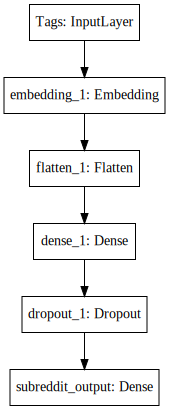

In [0]:
# Tags -> Subreddit 
# Single-Label Classification

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(inputs = ['Tags'], outputs=['Subreddit'])
SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))





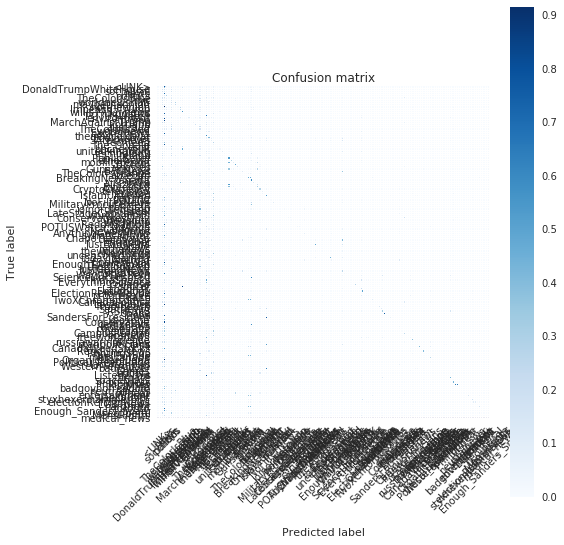

In [0]:
y_pred_probs = model.predict(x_test)
y_pred_probs = np.array(y_pred_probs)

y_pred = np.argmax(y_pred_probs,axis=1)
y_true = np.argmax(y_test['subreddit_output'],axis=1)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=True, classes_dict=subreddit_classes)

### Tags to Subreddit Samples

In [0]:
print_singlelabel_prediction_samples(y_true=y_test['subreddit_output'], 
                                     classes_dict=subreddit_classes)


Examples of exact matches (Actual Label = Top 1 Predicted Label):
Test record index #2 Prediction input:  Tags [ intelligence_report voting_software_company vr_systems    ]
News Urls: http://www.nydailynews.com/news/national/russian-hackers-targeted-vote-software-company-officials-report-article-1.3223517
Reddit Post Urls: https://www.reddit.com/r/politics/comments/6fh0uw/
Top 5 predicted labels: politics (0.32) The_Donald (0.15) news (0.06) EnoughTrumpSpam (0.04) Conservative (0.03) 
Actual label: politics [ #1 prediction]


Examples of approx. matches (Actual Label in Top 5 Predicted Labels):
Test record index #0 Prediction input:  Tags [ digital_currency bitcoin_exchange tokyo_stock_exchange virtual_currency   ]
News Urls: https://www.bloomberg.com/news/articles/2017-06-05/bitcoin-mania-infects-japanese-stock-market-s-smaller-listings
Reddit Post Urls: https://www.reddit.com/r/Bitcoin/comments/6fk8cc/
Top 5 predicted labels: BitcoinAll (0.36) Bitcoin (0.29) ethernews (0.16) CryptoCu

### BOWEntitiesEncoded to Subreddit Classification

In [0]:

# BOWEntitiesEncoded -> Subreddit 
# Single-Label Classification

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(inputs = ['BOWEntitiesEncoded'], outputs=['Subreddit'])

# SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

print_singlelabel_prediction_samples(y_true=y_test['subreddit_output'], classes_dict=subreddit_classes)

Using 150 unique values for subreddit
Using 32376 unique values for BOWEntitiesEncoded
Train on 110434 samples, validate on 12271 samples
Epoch 1/2
 - 45s - loss: 3.5663 - acc: 0.1836 - top_k_categorical_accuracy: 0.4605 - val_loss: 3.1908 - val_acc: 0.2349 - val_top_k_categorical_accuracy: 0.5445
Epoch 2/2
 - 46s - loss: 2.8923 - acc: 0.2726 - top_k_categorical_accuracy: 0.6065 - val_loss: 3.0652 - val_acc: 0.2497 - val_top_k_categorical_accuracy: 0.5727
Test data loss: 3.078; top 1 accuracy: 0.244; top 5 accuracy: 0.572;
Examples of exact matches (Actual Label = Top 1 Predicted Label):
Test record index #2 Prediction input:  BOWEntitiesEncoded [Decode function not implemented]
News Urls: http://www.nydailynews.com/news/national/russian-hackers-targeted-vote-software-company-officials-report-article-1.3223517
Reddit Post Urls: https://www.reddit.com/r/politics/comments/6fh0uw/
Top 5 predicted labels: politics (0.20) news (0.10) technology (0.09) The_Donald (0.05) worldnewshub (0.03) 


### BOWEntitiesEncoded and Domain to Subreddit Classification

Using 150 unique values for subreddit
Using 4232 unique values for domain
Using 32376 unique values for BOWEntitiesEncoded
Train on 110434 samples, validate on 12271 samples
Epoch 1/2
 - 91s - loss: 2.9042 - acc: 0.3077 - top_k_categorical_accuracy: 0.6233 - val_loss: 2.3575 - val_acc: 0.3844 - val_top_k_categorical_accuracy: 0.7294
Epoch 2/2
 - 92s - loss: 2.0985 - acc: 0.4194 - top_k_categorical_accuracy: 0.7815 - val_loss: 2.3281 - val_acc: 0.3645 - val_top_k_categorical_accuracy: 0.7388
Test data loss: 2.350; top 1 accuracy: 0.361; top 5 accuracy: 0.737;


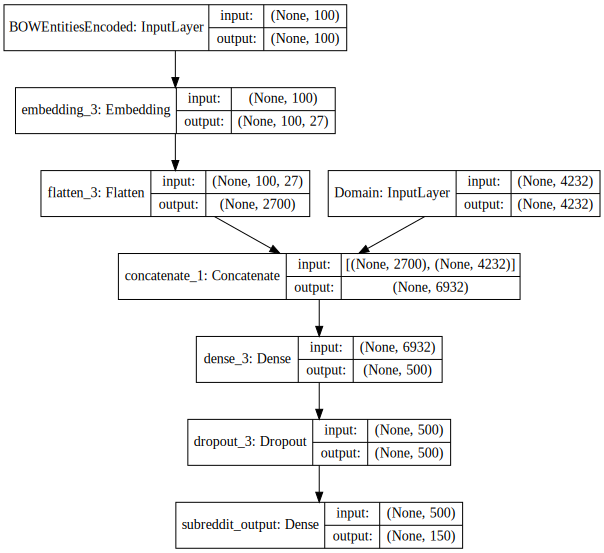

In [0]:
# BOWEntitiesEncoded, Domain -> Subreddit 
# Single-Label Classification

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(inputs = ['BOWEntitiesEncoded','Domain'], outputs=['Subreddit'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))



### BOWEntitiesEncoded and Domain to Subreddit Classification Samples

In [0]:
print_singlelabel_prediction_samples(y_true=y_test['subreddit_output'], 
                                     classes_dict=subreddit_classes,
                                     start_idx=10)

Examples of exact matches (Actual Label = Top 1 Predicted Label):
Test record index #12 Prediction input:  BOWEntitiesEncoded [Decode function not implemented] Domain [komonews.com]
News Urls: http://komonews.com/news/local/man-hit-by-bus-in-downtown-suffers-life-threatening-injuries
Reddit Post Urls: https://www.reddit.com/r/SeattleWA/comments/6f200s/
Top 5 predicted labels: SeattleWA (0.91) nottheonion (0.02) GunsAreCool (0.01) news (0.01) mobilityreport (0.01) 
Actual label: SeattleWA [ #1 prediction]


Examples of approx. matches (Actual Label in Top 5 Predicted Labels):
Test record index #10 Prediction input:  BOWEntitiesEncoded [Decode function not implemented] Domain [bbc.com]
News Urls: http://www.bbc.com/news/world-europe-40242531
Reddit Post Urls: https://www.reddit.com/r/worldnewshub/comments/6gmxq4/
Top 5 predicted labels: worldnews (0.19) worldnewshub (0.12) Raytheon (0.12) news (0.10) europe (0.07) 
Actual label: worldnewshub [ #2 prediction]


Examples of bad matches (Ac

### BOWEntitiesEncoded and Domain to Subreddit and RedditSubmitter Classification

Using 150 unique values for subreddit
Using 4232 unique values for domain
Using 2020 unique values for submitter
Using 32376 unique values for BOWEntitiesEncoded
Train on 110434 samples, validate on 12271 samples
Epoch 1/2
 - 116s - loss: 7.0773 - subreddit_output_loss: 3.0157 - submitter_output_loss: 4.0617 - subreddit_output_acc: 0.2963 - subreddit_output_top_k_categorical_accuracy: 0.6032 - submitter_output_acc: 0.2745 - submitter_output_top_k_categorical_accuracy: 0.5828 - val_loss: 5.8692 - val_subreddit_output_loss: 2.4344 - val_submitter_output_loss: 3.4348 - val_subreddit_output_acc: 0.3745 - val_subreddit_output_top_k_categorical_accuracy: 0.7168 - val_submitter_output_acc: 0.3253 - val_submitter_output_top_k_categorical_accuracy: 0.6586
Epoch 2/2
 - 116s - loss: 5.2865 - subreddit_output_loss: 2.2068 - submitter_output_loss: 3.0797 - subreddit_output_acc: 0.4076 - subreddit_output_top_k_categorical_accuracy: 0.7597 - submitter_output_acc: 0.3510 - submitter_output_top_k_categ

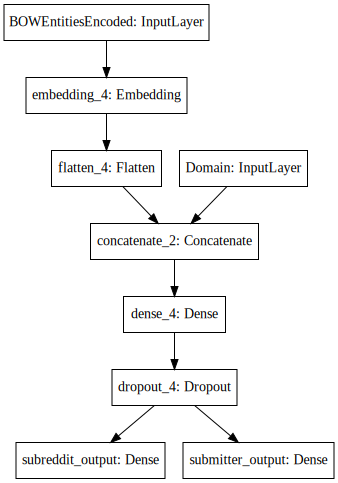

In [0]:
# BOWEntitiesEncoded, Domain -> Subreddit, RedditSubmitter 
# Single-Label Classification

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(inputs = ['BOWEntitiesEncoded','Domain'], outputs=['Subreddit','RedditSubmitter'])

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))


### Subreddit Multi-Label Classification

Waiting on bqjob_r6cd4702065323f8b_000001619305507b_2 ... (195s) Current status: DONE   


Size of reddit set: 89313 records
Size of train set: 70736 records
Size of test set: 17683 records
Using 150 unique values for subreddit
Using 4131 unique values for domain
Using 32208 unique values for BOWEntitiesEncoded
Train on 63662 samples, validate on 7074 samples
Epoch 1/2
 - 50s - loss: 0.0480 - acc: 0.9889 - top_k_categorical_accuracy: 0.5804 - val_loss: 0.0330 - val_acc: 0.9909 - val_top_k_categorical_accuracy: 0.7843
Epoch 2/2
 - 55s - loss: 0.0292 - acc: 0.9916 - top_k_categorical_accuracy: 0.8237 - val_loss: 0.0288 - val_acc: 0.9917 - val_top_k_categorical_accuracy: 0.8425
Test data loss: 0.029; top 1 accuracy: 0.992; top 5 accuracy: 0.839;


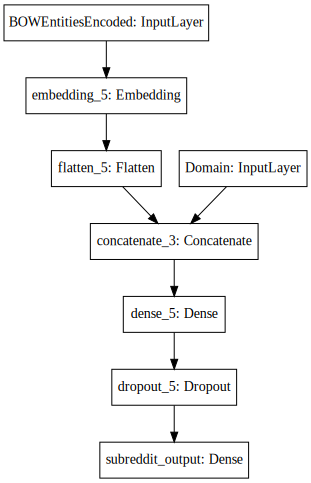

In [0]:
# BOWEntitiesEncoded, Domain -> Subreddit 
# Multi-Label Classification

current_learning_goal = 'MlbSubredditClassification'
set_columns_for_goal()
reddit_df = get_bq_data_for_goal()
(training_features, training_labels,validation_features, validation_labels) = create_train_test_features_labels()


(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(inputs = ['BOWEntitiesEncoded','Domain'], outputs=['Subreddit'])

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))


### Multi-label accuracy metrics

In [0]:
# Multi-label accuracy metrics

(y_pred,acc_score,h_loss,r_loss) = eval_multilabel_metrics(model, x_test, y_true = y_test['subreddit_output'])



Total correctly predicted: 4509 out of 17683 (absolute accuracy: 0.255)
Multi-label accuracy score: 0.255
Hamming loss: 0.014
Label ranking loss: 0.030


In [0]:
# Precision and Recall metrics
#plot_roc_curves(y_true = y_test['subreddit_output'], y_pred=y_pred)

summary_df = calc_multilabel_precision_recall(y_true = y_test['subreddit_output'], y_pred = y_pred)
#pd.set_option('display.max_rows', 1000)
print(summary_df)


                       sum_true  sum_pred  sum_TP    recall  precision  \
subreddit                                                                
<unknown>                   0.0       0.0     0.0       NaN        NaN   
politics                 2366.0    2652.0  1643.0  0.694421   0.619532   
worldnewshub             1957.0    3198.0  1108.0  0.566173   0.346467   
news                     1727.0    1225.0   653.0  0.378112   0.533061   
worldnews                1468.0    2319.0   823.0  0.560627   0.354894   
the_donald               1357.0    1501.0   725.0  0.534267   0.483011   
ecointernet              1302.0    1306.0   997.0  0.765745   0.763400   
thecolorisblue           1244.0    1320.0  1099.0  0.883441   0.832576   
willis7737_news           685.0     691.0   685.0  1.000000   0.991317   
india                     677.0     819.0   600.0  0.886263   0.732601   
ukpolitics                601.0     865.0   479.0  0.797005   0.553757   
raytheon                  485.0     89

### Multi-label accuracy by case type

In [0]:
(stats_num_samples, stats_num_cases, stats_num_cases_ratios, stats_by_casetype, example_by_casetype_bin) = calc_multilabel_accuracy_stats (
    y_true = y_test['subreddit_output'], y_pred=y_pred)


print('Samples by Number of Labels (2^x scale)')
prettyprint_nparray(stats_num_samples,
                    col_headers=['Num Labels'],
                    row_headers=gen_label_bin_headers(stats_num_samples.shape[0]-1))

print('\nSamples by Number of Labels X Case Type')
prettyprint_nparray(stats_num_cases,
                    col_headers=CASE_TYPE_HEADERS,
                    row_headers=gen_label_bin_headers(stats_num_cases.shape[0]-1))
                     
print('\nSamples by Number of Labels X Case Type (Ratios add up to 100%)')
prettyprint_nparray(stats_num_cases_ratios,
                    col_headers=CASE_TYPE_HEADERS,
                    row_headers=gen_label_bin_headers(stats_num_cases_ratios.shape[0]-1))

print('\nSamples by Case Type (Ratios add up to 100%)')
prettyprint_nparray(stats_by_casetype,
                    col_headers=['Ratio'],
                    row_headers=CASE_TYPE_HEADERS)

print('\nSample indeces by Number of Labels X Case Type')
prettyprint_nparray(example_by_casetype_bin,
                    col_headers=CASE_TYPE_HEADERS,
                    row_headers=gen_label_bin_headers(example_by_casetype_bin.shape[0]-1))




Samples by Number of Labels (2^x scale)
        Num Labels
1            11916
2             3129
3..4          1908
5..8           634
9..16           89
17..32           7

Samples by Number of Labels X Case Type
        100% TP+TN  50%+ TP  1-49% TP  0% TP
1             4066     4100         0   3750
2              345     2019         0    765
3..4            93      965       530    320
5..8             5      282       284     63
9..16            0       14        69      6
17..32           0        1         6      0

Samples by Number of Labels X Case Type (Ratios add up to 100%)
        100% TP+TN  50%+ TP  1-49% TP  0% TP
1            0.230    0.232     0.000  0.212
2            0.020    0.114     0.000  0.043
3..4         0.005    0.055     0.030  0.018
5..8         0.000    0.016     0.016  0.004
9..16        0.000    0.001     0.004  0.000
17..32       0.000    0.000     0.000  0.000

Samples by Case Type (Ratios add up to 100%)
            Ratio
100% TP+TN  0.255
50%+ TP  

### Multi-Label prediction examples

In [0]:

print_prediction_and_input(4666, notes='example of 100% TP+TN',
                           y_true=y_test['subreddit_output'], y_pred=y_pred, classes_dict=subreddit_classes)  

print('')

print_prediction_and_input(55, notes='example of 50%+ TP',
                           y_true=y_test['subreddit_output'], y_pred=y_pred, classes_dict=subreddit_classes)  



Test record index #4666 example of 100% TP+TN
News Urls: http://www.bbc.co.uk/news/uk-40453054
Reddit Post Urls: https://www.reddit.com/r/unitedkingdom/comments/6kdx84/ https://www.reddit.com/r/ukpolitics/comments/6kdwgn/ https://www.reddit.com/r/worldnewshub/comments/6ke5zi/ https://www.reddit.com/r/worldnews/comments/6kdxo7/ https://www.reddit.com/r/bbcnewsuk/comments/6kd8pk/

Prediction input:  BOWEntitiesEncoded [Decode function not implemented] Domain [bbc.co.uk]
Predicted classes: worldnewshub,worldnews,ukpolitics,unitedkingdom,bbcnewsuk
True/Actual classes: worldnewshub,worldnews,ukpolitics,unitedkingdom,bbcnewsuk

Test record index #55 example of 50%+ TP
News Urls: https://heatst.com/politics/nj-democratic-strategist-starts-huntrepublicans-and-huntrepublicancongressman/
Reddit Post Urls: https://www.reddit.com/r/The_Donald/comments/6i3gcb/ https://www.reddit.com/r/The_Donald/comments/6hp3z7/ https://www.reddit.com/r/Conservative/comments/6hp24w/ https://www.reddit.com/r/Newsdum

### Adding Submitter as Predictor of Subreddit

Waiting on bqjob_r4842d4f23f38c65_00000161932cf8b6_3 ... (224s) Current status: DONE   


Size of reddit set: 154931 records
Size of train set: 122705 records
Size of test set: 30676 records
Using 150 unique values for subreddit
Using 4232 unique values for domain
Using 2029 unique values for submitter
Using 32376 unique values for BOWEntitiesEncoded
Train on 110434 samples, validate on 12271 samples
Epoch 1/2
 - 114s - loss: 1.5813 - acc: 0.6281 - top_k_categorical_accuracy: 0.8191 - val_loss: 0.9967 - val_acc: 0.7303 - val_top_k_categorical_accuracy: 0.9113
Epoch 2/2
 - 117s - loss: 0.8020 - acc: 0.7693 - top_k_categorical_accuracy: 0.9416 - val_loss: 0.9802 - val_acc: 0.7279 - val_top_k_categorical_accuracy: 0.9178
Test data loss: 0.992; top 1 accuracy: 0.720; top 5 accuracy: 0.916;


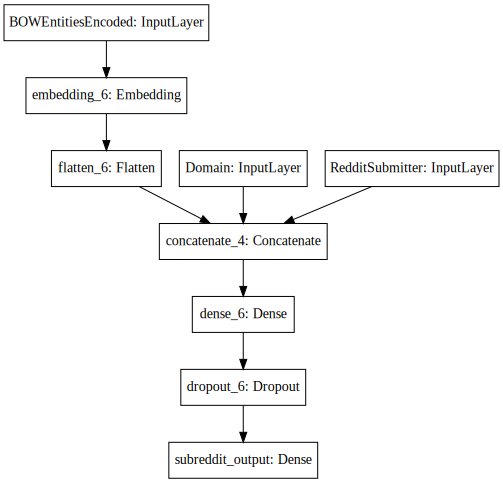

In [0]:
# BOWEntitiesEncoded, Domain, RedditSubmitter -> Subreddit
# Single-label classification

current_learning_goal = 'SubredditClassification'
set_columns_for_goal()
reddit_df = get_bq_data_for_goal()
(training_features, training_labels,validation_features, validation_labels) = create_train_test_features_labels()

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(inputs = ['BOWEntitiesEncoded','Domain','RedditSubmitter'], outputs=['Subreddit'])

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

##Predicting engagement metrics (Score, Number of Commenters, Number of Comments)

###Explore data distributions

In [7]:
current_learning_goal = 'CommentsClassification'
current_exclude_autosubreddits = False
current_sample_frac = 0.5
set_columns_for_goal()
reddit_df = get_bq_data_for_goal()
(training_features, training_labels,validation_features, validation_labels) = create_train_test_features_labels()




Waiting on bqjob_r6d22cca32cd339fb_00000161b08308a8_1 ... (194s) Current status: DONE   

Building model with learning goal: CommentsClassification, using label column: ScoreBin, using feature columns: ['Url', 'RedditPostUrl', 'Domain', 'Tags', 'BOWEntitiesEncoded', 'RedditSubmitter', 'Subreddit', 'NumCommentersBin', 'ScoreBin', 'ExampleWeight']

Size of reddit set: 425548 records
Size of train set: 170220 records
Size of test set: 42554 records


Reddit dataset summary:


,Score,NumCommenters,NumComments,NumCommentersClipped,NumCommentsClipped,ScoreClipped,NumCommentersLogScaled,NumCommentsLogScaled,ScoreLogScaled,ExampleWeight
count,425548.000000,425548.000000,425548.000000,425548.000000,425548.000000,425548.000000,425548.000000,425548.000000,425548.000000,425548.000000
mean,58.957845,4.343301,7.522677,4.343301,7.522677,41.188446,0.204004,0.224306,0.573182,0.064570
std,1073.187485,52.371072,106.041110,52.371072,106.041110,424.024024,0.416052,0.468542,0.568500,0.108779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028566
25%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.301030,0.028566
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.301030,0.028566
75%,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.301030,0.301030,0.602060,0.028566
max,100206.000000,8146.000000,23586.000000,8146.000000,23586.000000,9999.000000,3.910998,4.372673,4.000000,1.000000


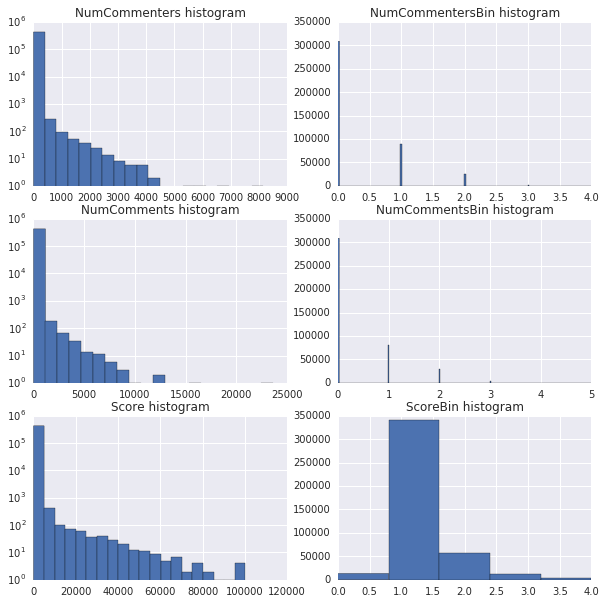

In [8]:
print("Reddit dataset summary:")

display.display(reddit_df.describe())

if current_learning_goal == "CommentsRegression" or current_learning_goal == "CommentsClassification":

  plt.figure(figsize=(10,10))
  plt.subplot(321)
  plt.hist(reddit_df["NumCommenters"],bins=20)
  plt.yscale('log')
  plt.title("NumCommenters histogram")

  plt.subplot(322)
  plt.hist(pd.to_numeric(reddit_df["NumCommentersBin"], errors='coerce'),bins='auto')
  plt.title("NumCommentersBin histogram")

  plt.subplot(323)
  plt.hist(reddit_df["NumComments"],bins=20)
  plt.yscale('log')
  plt.title("NumComments histogram")

  plt.subplot(324)
  plt.hist(pd.to_numeric(reddit_df["NumCommentsBin"], errors='coerce'),bins='auto')
  plt.title("NumCommentsBin histogram")

  plt.subplot(325)
  plt.hist(reddit_df["Score"],bins=20)
  plt.yscale('log')
  plt.title("Score histogram")

  plt.subplot(326)
  plt.hist(pd.to_numeric(reddit_df["ScoreBin"], errors='coerce'),bins=5)
  plt.title("ScoreBin histogram")


  plt.show()

Using 5291 unique values for domain
Using 49586 unique values for Tags
Using 6 unique values for ScoreBin
Using 6 unique values for NumCommentersBin
Train on 153198 samples, validate on 17022 samples
Epoch 1/1
 - 106s - loss: 1.2296 - scorebin_output_loss: 0.5986 - numcommentersbin_output_loss: 0.6310 - scorebin_output_acc: 0.8005 - scorebin_output_top_k_accuracy: 0.9330 - numcommentersbin_output_acc: 0.7357 - numcommentersbin_output_top_k_accuracy: 0.9336 - val_loss: 1.1873 - val_scorebin_output_loss: 0.5758 - val_numcommentersbin_output_loss: 0.6115 - val_scorebin_output_acc: 0.8008 - val_scorebin_output_top_k_accuracy: 0.9335 - val_numcommentersbin_output_acc: 0.7395 - val_numcommentersbin_output_top_k_accuracy: 0.9336
Test metrics: total loss: 1.174; output_1 loss: 0.570; output_2 loss: 0.604; output_1 top 1 accuracy: 0.804; output_1 top 2 accuracy: 0.936; output_2 top 1 accuracy: 0.745; output_2 top 2 accuracy: 0.936;


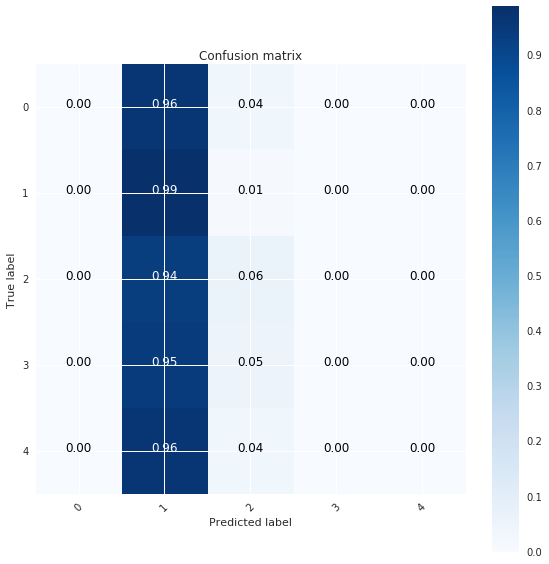

In [9]:
current_epochs = 1

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(
    inputs = ['Domain','Tags'], 
    outputs=['ScoreBin','NumCommentersBin'],
    k_of_top_k_accuracy=2)

(y_true, y_pred) = get_true_and_predicted_labels(
    model=model,
    x_test=x_test, 
    y_test_selected=y_test['scorebin_output'], 
    label_classes=scorebin_classes)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=True, class_order=scorebin_classes)



Using 5291 unique values for domain
Using 49586 unique values for Tags
Using 6 unique values for ScoreBin
Using 6 unique values for NumCommentersBin
Train on 153198 samples, validate on 17022 samples
Epoch 1/1
 - 107s - loss: 0.1608 - scorebin_output_loss: 0.0872 - numcommentersbin_output_loss: 0.0736 - scorebin_output_acc: 0.6951 - scorebin_output_top_k_accuracy: 0.8045 - numcommentersbin_output_acc: 0.6871 - numcommentersbin_output_top_k_accuracy: 0.8685 - val_loss: 0.1598 - val_scorebin_output_loss: 0.0860 - val_numcommentersbin_output_loss: 0.0738 - val_scorebin_output_acc: 0.6959 - val_scorebin_output_top_k_accuracy: 0.7906 - val_numcommentersbin_output_acc: 0.7152 - val_numcommentersbin_output_top_k_accuracy: 0.8845
Test metrics: total loss: 1.612; output_1 loss: 0.888; output_2 loss: 0.723; output_1 top 1 accuracy: 0.701; output_1 top 2 accuracy: 0.796; output_2 top 1 accuracy: 0.714; output_2 top 2 accuracy: 0.885;


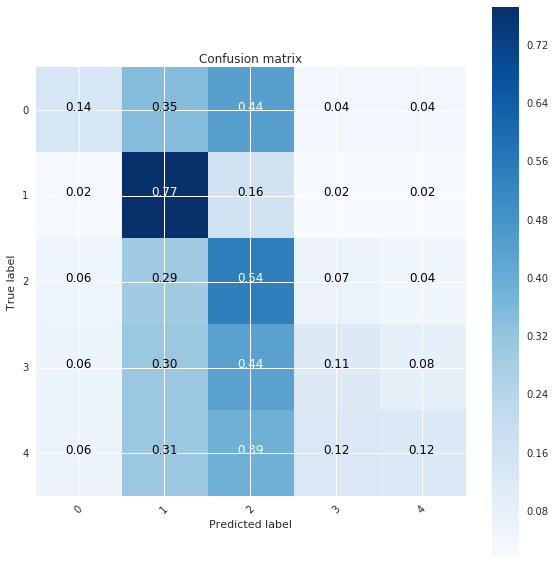

In [10]:
(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(
    inputs = ['Domain','Tags'], 
    outputs=['ScoreBin','NumCommentersBin'],
    use_sample_weights=True,
    k_of_top_k_accuracy=2)

(y_true, y_pred) = get_true_and_predicted_labels(
    model=model,
    x_test=x_test, 
    y_test_selected=y_test['scorebin_output'], 
    label_classes=scorebin_classes)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=True, class_order=scorebin_classes)


Using 5872 unique values for subreddit
Using 2000 unique values for submitter
Using 6 unique values for ScoreBin
Using 6 unique values for NumCommentersBin
Train on 153198 samples, validate on 17022 samples
Epoch 1/1
 - 110s - loss: 0.1222 - scorebin_output_loss: 0.0653 - numcommentersbin_output_loss: 0.0569 - scorebin_output_acc: 0.7614 - scorebin_output_top_k_accuracy: 0.8552 - numcommentersbin_output_acc: 0.7914 - numcommentersbin_output_top_k_accuracy: 0.9314 - val_loss: 0.1166 - val_scorebin_output_loss: 0.0619 - val_numcommentersbin_output_loss: 0.0547 - val_scorebin_output_acc: 0.7588 - val_scorebin_output_top_k_accuracy: 0.8607 - val_numcommentersbin_output_acc: 0.8035 - val_numcommentersbin_output_top_k_accuracy: 0.9383
Test metrics: total loss: 1.019; output_1 loss: 0.563; output_2 loss: 0.456; output_1 top 1 accuracy: 0.760; output_1 top 2 accuracy: 0.861; output_2 top 1 accuracy: 0.805; output_2 top 2 accuracy: 0.938;


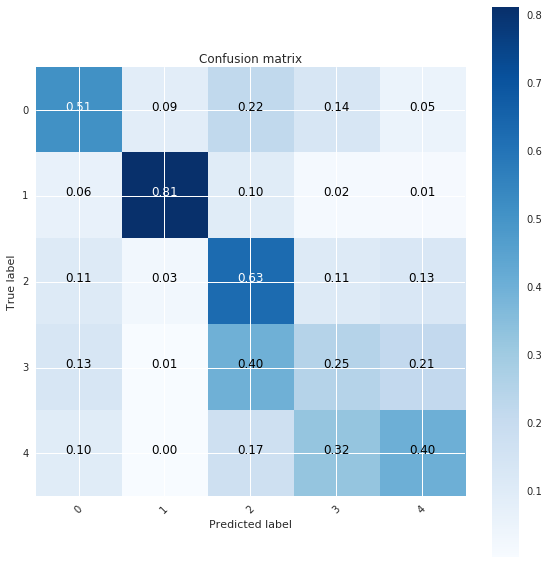

In [8]:
current_epochs = 1

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(
    inputs = ['Subreddit','RedditSubmitter'], 
    outputs=['ScoreBin','NumCommentersBin'],
    use_sample_weights=True,
    k_of_top_k_accuracy=2)

#SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

(y_true, y_pred) = get_true_and_predicted_labels(
    model=model,
    x_test=x_test, 
    y_test_selected=y_test['scorebin_output'], 
    label_classes=scorebin_classes)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=True, class_order=scorebin_classes)



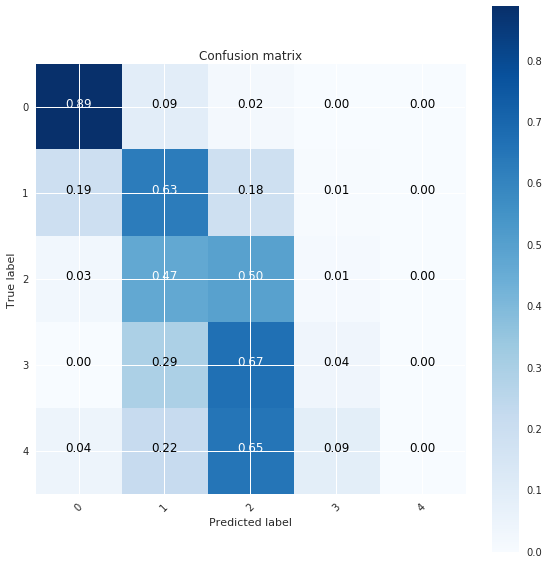

In [9]:
# How well is CM distributed for NumCommenters, when ScoreBin is used for weights
(y_true, y_pred) = get_true_and_predicted_labels(
    model=model,
    x_test=x_test, 
    y_test_selected=y_test['numcommentersbin_output'], 
    label_classes=scorebin_classes,
    multi_output=True,
    output_idx=1)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=True, class_order=scorebin_classes)

Size of train set: 170220 records
Size of test set: 42554 records
Using 5872 unique values for subreddit
Using 2039 unique values for submitter
Using 6 unique values for ScoreBin
Using 6 unique values for NumCommentersBin
Train on 153198 samples, validate on 17022 samples
Epoch 1/1
 - 107s - loss: 0.0092 - scorebin_output_loss: 0.0044 - numcommentersbin_output_loss: 0.0048 - scorebin_output_acc: 0.7941 - scorebin_output_top_k_accuracy: 0.8910 - numcommentersbin_output_acc: 0.7517 - numcommentersbin_output_top_k_accuracy: 0.8856 - val_loss: 0.0087 - val_scorebin_output_loss: 0.0043 - val_numcommentersbin_output_loss: 0.0045 - val_scorebin_output_acc: 0.7712 - val_scorebin_output_top_k_accuracy: 0.8777 - val_numcommentersbin_output_acc: 0.7343 - val_numcommentersbin_output_top_k_accuracy: 0.8688
Test metrics: total loss: 1.197; output_1 loss: 0.555; output_2 loss: 0.642; output_1 top 1 accuracy: 0.774; output_1 top 2 accuracy: 0.881; output_2 top 1 accuracy: 0.737; output_2 top 2 accurac

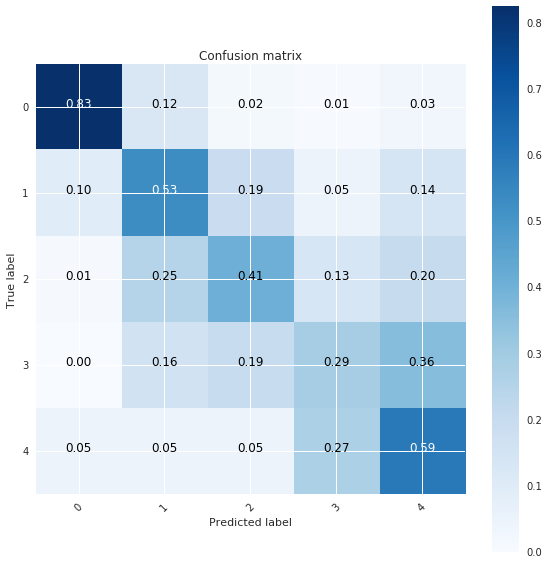

In [8]:
# Change label to NumCommentersBin and check CM composition now

current_epochs = 1
current_label_col = 'NumCommentersBin'
current_inverse_frequency_pow = 0.85

(training_features, training_labels,validation_features, validation_labels) = create_train_test_features_labels()

(model, history, x_train, x_test, y_train, y_test) = compile_and_fit_model(
    inputs = ['Subreddit','RedditSubmitter'], 
    outputs=['ScoreBin','NumCommentersBin'],
    use_sample_weights=True,
    k_of_top_k_accuracy=2)

(y_true, y_pred) = get_true_and_predicted_labels(
    model=model,
    x_test=x_test, 
    y_test_selected=y_test['numcommentersbin_output'], 
    label_classes=numcommentersbin_classes,
    multi_output=True,
    output_idx=1)

plot_confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=True, class_order=numcommentersbin_classes)
